In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [10]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8* len(words))
n2 = int(0.9* len(words))

Xt, Yt = build_dataset(words[:n1])
Xv, Yv = build_dataset(words[n1:n2])
Xe, Ye = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

In [12]:
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
            return self.out

    def parameters(self):
        return [self.gamma, self.beta]
        

In [13]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [20]:
N_embd = 10
N_vocab = 27
N_hidden = 100
N_block = 3

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((N_vocab, N_embd), generator = g)

layers = [
    Linear(N_embd*N_block, N_hidden, bias = False), BatchNorm1d(N_hidden), Tanh(),
    Linear( N_hidden, N_hidden, bias = False),      BatchNorm1d(N_hidden), Tanh(),
    Linear( N_hidden, N_hidden, bias = False),      BatchNorm1d(N_hidden), Tanh(),
    Linear( N_hidden, N_hidden, bias = False),      BatchNorm1d(N_hidden), Tanh(),
    Linear( N_hidden, N_hidden, bias = False),      BatchNorm1d(N_hidden), Tanh(),
    Linear( N_hidden, N_vocab, bias = False),       BatchNorm1d(N_vocab), 
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('Parameters Count : ', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

Parameters Count :  47024


In [21]:
Max_steps = 200000
N_batch = 32
lossi = []
ud = []

In [31]:
for i in range(Max_steps):
    ix = torch.randint(0, Xt.shape[0], (N_batch,), generator = g)
    Xb, Yb = Xt[ix], Yt[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i< 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i == 0:
        s = ' Epoch'
        print(s,' | Loss')
    if i%10000 == 0:
        print(f'{i:7d} | {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(( lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    #if i >= 1000:
     #   break

 Epoch  | Loss
      0 | 1.9342
  10000 | 2.3953
  20000 | 1.8547
  30000 | 2.0216
  40000 | 1.9783
  50000 | 1.9689
  60000 | 2.4717
  70000 | 2.4341
  80000 | 2.2110
  90000 | 2.0668
 100000 | 1.9190
 110000 | 2.1007
 120000 | 1.7488
 130000 | 2.0298
 140000 | 1.6755
 150000 | 2.2241
 160000 | 2.3646
 170000 | 2.1060
 180000 | 2.0928
 190000 | 2.0530


### Activation Distribution

Layer  2 |  Tanh | Mean +0.01 | Std +0.70 | Saturated 17.72%
Layer  5 |  Tanh | Mean -0.01 | Std +0.76 | Saturated 21.44%
Layer  8 |  Tanh | Mean +0.00 | Std +0.78 | Saturated 23.00%
Layer 11 |  Tanh | Mean +0.02 | Std +0.80 | Saturated 25.47%
Layer 14 |  Tanh | Mean +0.02 | Std +0.81 | Saturated 24.53%


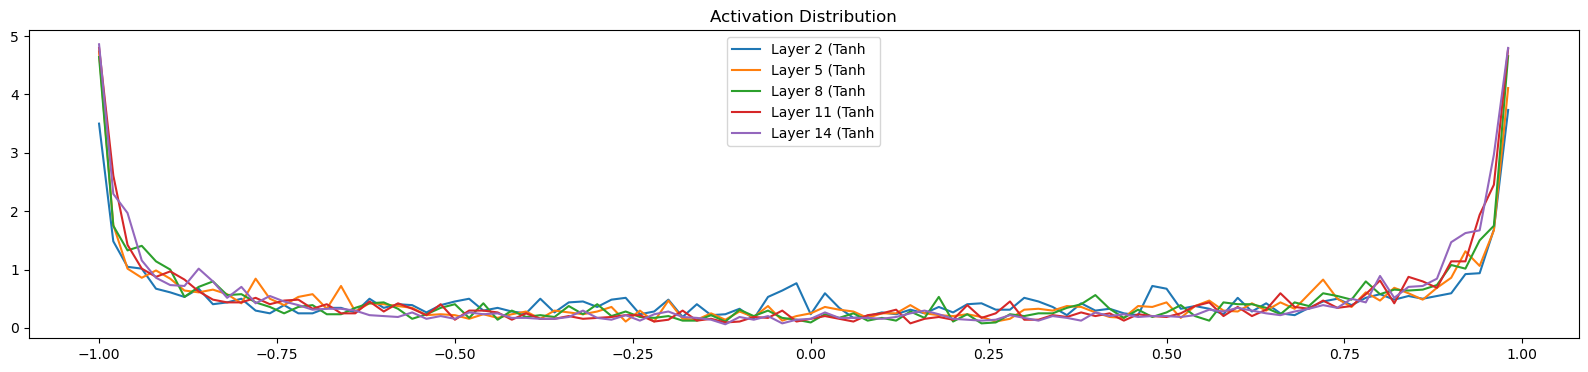

In [36]:
plt.figure(figsize = (20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        A = (t.abs() > 0.97).float().mean()*100
        class_name = layer.__class__.__name__
        print('Layer %2d | %5s | Mean %+.2f | Std %+.2f | Saturated %.2f%%' % (i, class_name, t.mean(), t.std(), A))
        hy,hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({class_name}')
    plt.legend(legends);
    plt.title('Activation Distribution')

### Gradient Distribution

Layer  2 |  Tanh | Mean -0.00 | Std 3.859717e-03
Layer  5 |  Tanh | Mean +0.00 | Std 3.630176e-03
Layer  8 |  Tanh | Mean -0.00 | Std 3.585649e-03
Layer 11 |  Tanh | Mean +0.00 | Std 3.380599e-03
Layer 14 |  Tanh | Mean +0.00 | Std 3.910874e-03


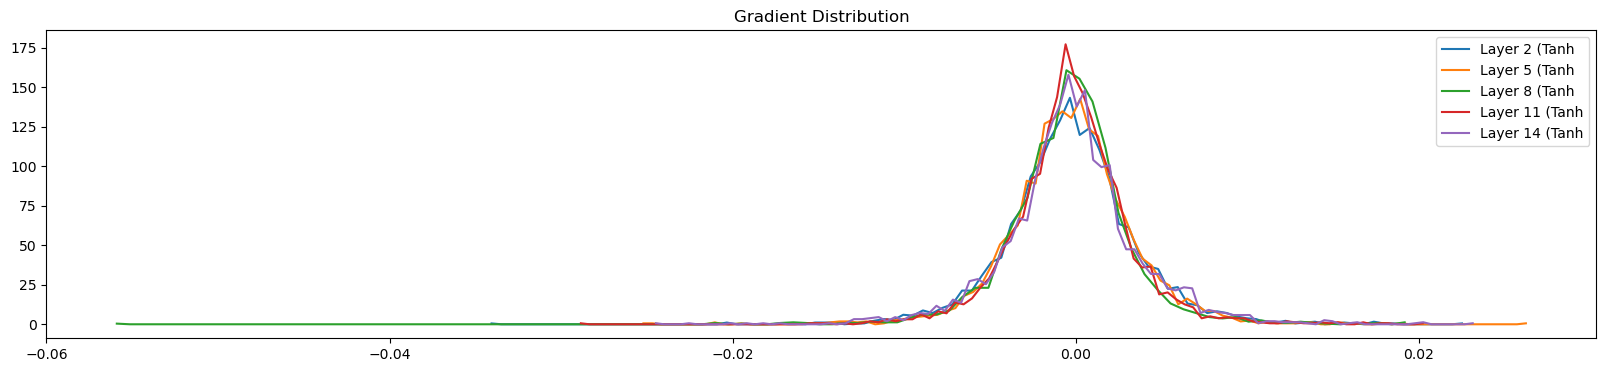

In [37]:
plt.figure(figsize = (20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        class_name = layer.__class__.__name__
        print('Layer %2d | %5s | Mean %+.2f | Std %e' % (i, class_name, t.mean(), t.std()))
        hy,hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({class_name}')
    plt.legend(legends);
    plt.title('Gradient Distribution')

### Weight Gradient Distribution

Weight   (27, 10) | Mean -0.000000 | Std 1.378443e-02 | grad:data ratio 1.191345e-02 
Weight  (30, 100) | Mean +0.000095 | Std 8.055616e-03 | grad:data ratio 1.927814e-02 
Weight (100, 100) | Mean -0.000026 | Std 5.126183e-03 | grad:data ratio 2.018188e-02 
Weight (100, 100) | Mean +0.000017 | Std 5.517943e-03 | grad:data ratio 2.198764e-02 
Weight (100, 100) | Mean +0.000036 | Std 5.204807e-03 | grad:data ratio 2.168616e-02 
Weight (100, 100) | Mean -0.000003 | Std 4.797605e-03 | grad:data ratio 2.137723e-02 
Weight  (100, 27) | Mean +0.000120 | Std 8.769826e-03 | grad:data ratio 2.376457e-02 


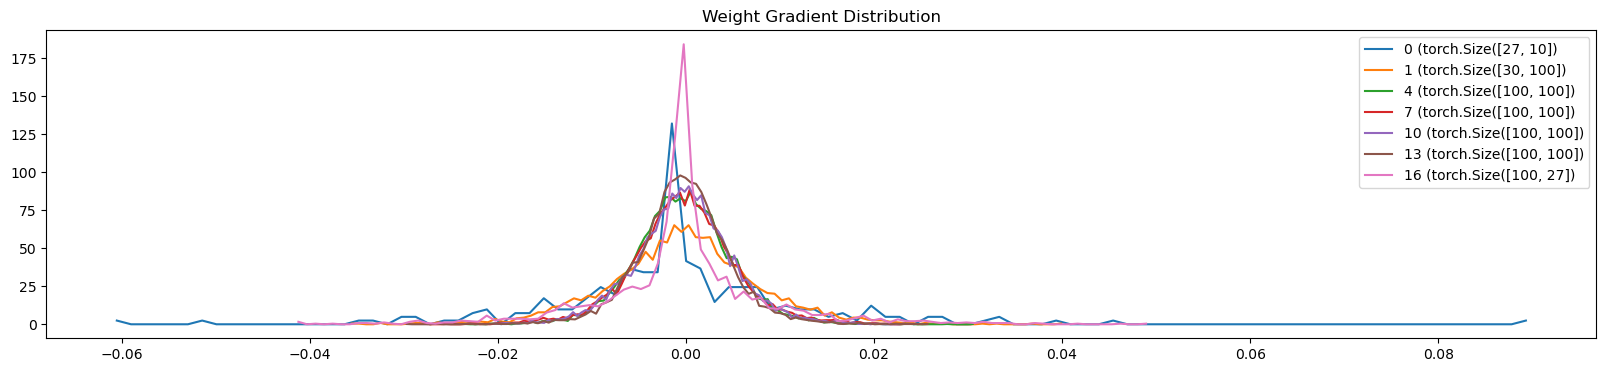

In [39]:
plt.figure(figsize = (20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('Weight %10s | Mean %+f | Std %e | grad:data ratio %e ' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy,hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} ({p.shape}')
    plt.legend(legends)
    plt.title('Weight Gradient Distribution')
    

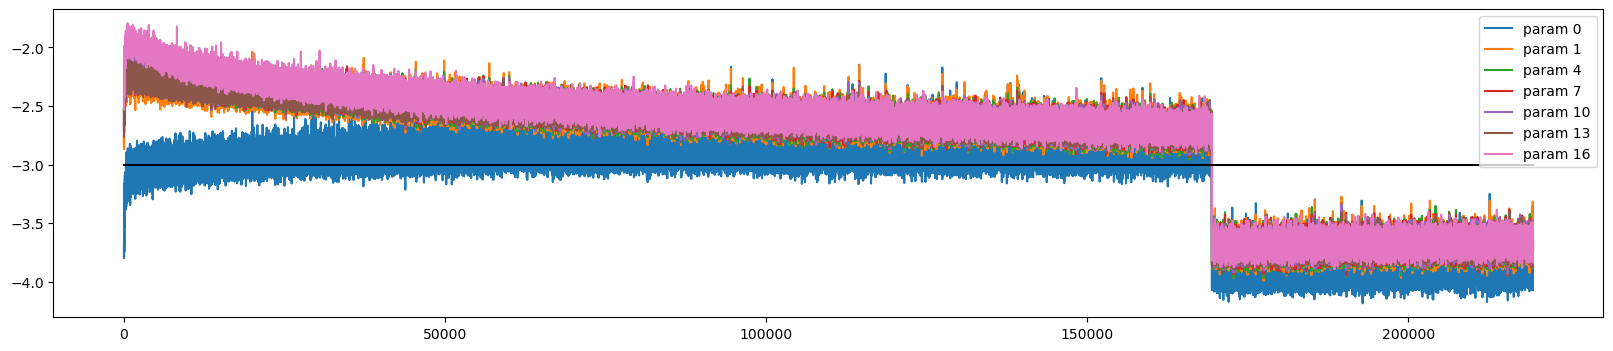

In [40]:
plt.figure(figsize = (20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends);

In [42]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train':(Xt, Yt),
        'val': (Xv, Yv),
        'test': (Xe, Ye),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.995328426361084
val 2.0755200386047363
test 2.0777907371520996


In [49]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0],-1)
        for layer in layers:
            x = layer(x)
            print(x)
            break
        logits = x
        probs = F.softmax(logits, dim =1)
        ix = torch.multinomial(probs,num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

tensor([[-3.7256,  1.8549, -1.5111,  0.3784, -0.1591, -1.4877, -2.3843, -1.5374,
         -0.3743,  0.3631, -0.3933,  0.1228,  1.4427, -0.3851, -0.1630,  0.5341,
         -0.6650, -2.1289,  1.3258,  1.9738, -1.4494, -5.0744,  0.8852,  1.6261,
          1.8754,  0.5053,  0.4244,  0.2839, -2.2654,  0.2765, -0.0104,  1.0839,
          1.2737,  0.9435,  0.4460, -2.1528, -0.3506, -2.1627,  0.5993, -1.2232,
          0.3889, -0.7699, -0.9026, -0.8939,  0.5053, -0.7274,  1.2078, -0.4777,
         -0.9513,  1.6132,  1.8346, -0.7461,  1.5012,  1.0981, -0.5563,  0.6701,
          0.0873, -1.8150,  0.0401, -1.2648,  0.1378,  2.0201,  0.2684, -0.4679,
          4.1882,  1.6569,  0.4238, -1.0029, -2.1099,  1.1983,  0.3329,  1.6439,
         -2.2026, -1.1952, -0.6443,  0.8425,  3.5526, -0.6601,  0.4690, -1.0694,
          1.8048,  1.0335, -0.3977,  2.2826,  0.1877,  0.1841, -2.7273,  0.1441,
          0.9704, -1.0865,  1.5541,  0.2013,  0.2323,  0.2361, -0.7839, -0.3156,
         -1.4697, -0.3987, -

IndexError: index 76 is out of bounds for dimension 0 with size 27

In [51]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('Input : mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [52]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [53]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
